# Import libraries 

In [1]:
import sys
from pathlib import Path
sys.path.insert(0,'..')
import re
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from src.utils.hdf_tools import load_from_hdf_with_regex
from src.visualisation.visualisation import plot_hdf

In [2]:
from src.utils.dataset_utils import align_u_diode_data, drop_quenched_magnets, u_diode_simulation_to_df, \
    u_diode_data_to_df, data_to_xarray, get_u_diode_data_alignment_timestamps

# Load mp3 data

In [4]:
# Load context data
df_context_path = Path("../data/RB_snapshot_context.csv")
df_context = pd.read_csv(df_context_path)
current_level = 11000
dI_dt = 10
df_context_subset = df_context[(df_context["I_Q_M"] > current_level - 500) &
                               (df_context["I_Q_M"] < current_level + 500) &
                               (df_context["dI_dt_from_data"] > dI_dt - 2) &
                               (df_context["dI_dt_from_data"] < dI_dt + 2)]

In [51]:
# Load labels
true_label_name = "manual classification"
pred_label_name = "ML classification"
label_names = ["true_2_normal",
               "true_2_long_unbalanced",
               "true_2_very_long_unbalanced",
               "true_2_boardA_boardB"]

labels_path = Path("../data/UQS0_labels/dest_file_v02.xlsx")
df_event_labels = pd.read_excel(labels_path)
df_event_labels["magnet"] = df_event_labels["event"].apply(lambda x: x.split("_")[0])
df_magnet_labels = df_event_labels.set_index('magnet')[label_names] #generate_magnet_labels_from_event(df_event_labels, label_names)

experiment_path = Path("../data/UQS0_labels/Outliers_summary_Meas_2021_2022_NoZero.xlsx")
df_all_experiments = pd.read_excel(experiment_path)
df_experiment = df_all_experiments[(df_all_experiments["Current_level"] == current_level) &
                                    (df_all_experiments["Expected_dI_dt"] == dI_dt)]

# Load Data

In [88]:
def filter_df(df_filt, window_size, step):

    # create a series of group labels based on the step
    offset = abs(df_filt.index.min())  # rolling cannot handle zero passing
    df_filt.index = df_filt.index + offset
    group_labels = np.arange(len(df_filt)) // step

    # apply the rolling method to each group
    med_df = df_filt.groupby(group_labels)\
        .rolling(window_size, center=True).mean().reset_index(level=0, drop=True).dropna(how="all")

    return med_df


def load_uqs0_data_from_hdf5(df_events: pd.DataFrame, file_path: Path) -> pd.DataFrame:
    """
    loads uqs0 data from hdf5 given DataFrame with columns 'Circuit' and 'timestamp_fgc'
    :param df_events: dataframe with columns 'Circuit' and 'timestamp_fgc'
    :param file_path: path to hdf5 files
    :return: DataFrame with magnets as columns and time as index
    """
    data_list = []
    data_columns = []
    
    df_features = pd.DataFrame
    for j, row in df_events.iterrows():
        file_name = f"RB_{row['Circuit']}_{row['timestamp_fgc']}"
        data = load_from_hdf_with_regex(file_path / (file_name + ".hdf5"), regex_list=['U_QS0'])

        df = u_diode_data_to_df(data, len_data=len(data[0]))

        window_size = 100
        step = 100
        df = df.iloc[96:]
        df = filter_df(df, window_size, step)
        magnets = [x.split("_")[0] for x in df.filter(regex="_A").columns.values]
        data_columns.append(magnets)

        data_list.append(np.vstack([df.filter(regex="_A"), df.filter(regex="_B")]).T)
        
    
    na_data = np.stack(data_list)
    data = na_data.reshape(-1, na_data.shape[-1])

    df_data = pd.DataFrame(data.T,
                           columns=np.array(data_columns).reshape(-1),
                           index=np.hstack([df.index.values, df.index.values]))

    print(f"Length of one Signal: {len(df)}")
    return df_data

In [89]:
# Load data
data_path = Path('/eos/project/s/steam/measurement_database/RB/data') # Path('/eos/project/s/steam/measurement_database/RB/data')
df_data = load_uqs0_data_from_hdf5(df_context_subset, data_path)[df_magnet_labels.index.values]

Length of one Signal: 40


# Calculate features

In [78]:
df_features = df_data.iloc[:35].mean(axis=0).to_frame(name="A_mean")
df_features["A_max"] = df_data.iloc[:35].max(axis=0)
df_features["B_mean"] = df_data.iloc[35:].mean(axis=0)
df_features["B_max"] = df_data.iloc[35:].max(axis=0)

df_features["diff_AB_mean"] = abs(df_features["A_mean"] - df_features["B_mean"])
df_features["diff_A_mean_max"] = (df_features["A_max"] - df_features["A_mean"])
df_features["diff_B_mean_max"] = (df_features["B_max"] - df_features["B_mean"])
df_features["diff_AB_mean_max"] = df_features[["diff_A_mean_max", "diff_B_mean_max"]].mean(axis=1)


In [90]:
df_magnet_labels.columns.values


array(['true_2_normal', 'true_2_long_unbalanced',
       'true_2_very_long_unbalanced', 'true_2_boardA_boardB'],
      dtype=object)

(0.0, 0.03)

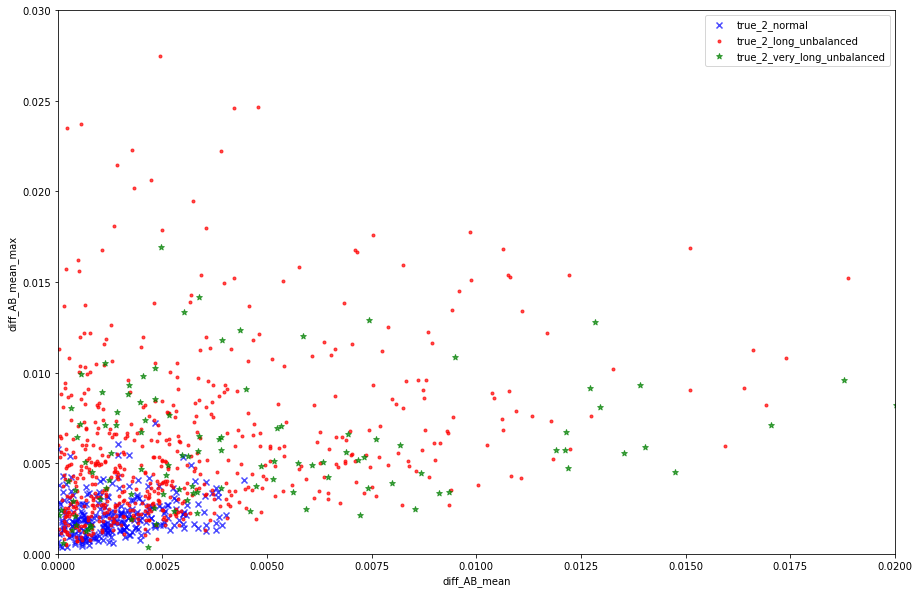

In [91]:
plt.subplots(figsize=(15,10))
colors = ["b", "r", "g", "orange"]
markers = ["x", ".", "*", "<"]

labels = ['true_2_normal', 
         'true_2_long_unbalanced',
         'true_2_very_long_unbalanced']
for l, label in enumerate(labels):
    label_idx = df_magnet_labels[df_magnet_labels[label] ==1].index.values
    plt.scatter(x=df_features.loc[label_idx, "diff_AB_mean"], y=df_features.loc[label_idx, "diff_AB_mean_max"], color=colors[l], marker=markers[l], alpha=0.7, label=label)
    
plt.legend()           
plt.xlabel("diff_AB_mean")
plt.ylabel("diff_AB_mean_max") 
plt.xlim(0, 0.02)
plt.ylim(0, 0.03)

# Plot all data

In [11]:
# Process data
clip = 0.15
n_signals = 2  # Board A & B
df_data[(df_data > clip)] = clip
df_data[df_data < -clip] = -clip
data = df_data.T.values
X = np.nan_to_num(data)
target_names = label_names
y = df_magnet_labels.loc[df_magnet_labels.index.values, target_names].values
y_argmax = np.argmax(y, axis=1)


X_train = X
y_train = y

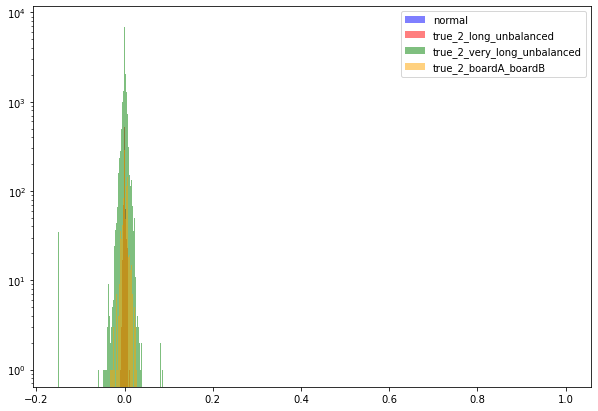

In [14]:
plt.figure(figsize=(10, 7))
plt.hist(X_train[(y_train==[0, 0, 0, 0]).all(axis=-1)].reshape(-1), bins=300, color="b", alpha=0.5)
#plt.hist(X_train[y_train==1].reshape(-1), bins=300, color="r", alpha=0.5)
plt.hist(X_train[y_train[:,0]==1].reshape(-1), bins=300, color="r", alpha=0.5)
plt.hist(X_train[y_train[:,1]==1].reshape(-1), bins=300, color="g", alpha=0.5)
plt.hist(X_train[y_train[:,2]==1].reshape(-1), bins=300, color="orange", alpha=0.5)
plt.legend(["normal"]+label_names[1:])

plt.yscale("log")
plt.show()